<!--Copyright © ZOMI 适用于[License](https://github.com/Infrasys-AI/AIInfra)版权许可-->

# CODE 02: FastVLM-0.5B 量化对比

> Author by: 汪袁烁, ZOMI

在深度学习应用中，模型的大小和计算效率往往是实际部署时需要考虑的关键因素。特别是对于像 FastVLM 这样的视觉语言模型，即使是 0.5B 参数规模，在资源受限的设备上运行也可能面临挑战。

模型量化是解决这一问题的有效方法，它通过减少模型参数和计算的数值精度来降低显存占用并提高推理速度。今天我们就来实际对比不同量化策略对模型性能的影响。

## 1. 模型量化基础

量化的核心思想是将神经网络中的浮点数权重和激活值转换为定点数表示。最常用的是将 32 位浮点数（FP32）转换为更低位数的整数表示。

对于权重量化，我们通常使用以下公式将浮点数转换为整数：

$$ q = \text{round}(r / s + z) $$

其中：

- $r$ 是原始浮点数值
- $s$ 是缩放因子（scale）
- $z$ 是零点偏移（zero point）
- $q$ 是量化后的整数值

常见的量化配置有：

- W4A4：权重和激活值都使用 4 位整数
- W8A8：权重和激活值都使用 8 位整数 
- W4A16：权重使用 4 位整数，激活值使用 16 位整数

## 2. 实验环境准备

首先，我们需要安装必要的库。我们将使用 Hugging Face 的 transformers 库加载模型，以及 accelerate 库来帮助管理显存使用。

In [1]:
# 安装所需库
!pip install transformers accelerate torch pillow

然后，我们导入必要的模块：

In [2]:
import torch
import time
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoImageProcessor,AutoProcessor
from PIL import Image
import os

/home/yswang/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. 加载 FastVLM-0.5B和数据准备

让我们先加载原始的 FastVLM-0.5B 模型，作为基准参考。



### 加载模型
完成下载之后便可以加载 FastVLM 跑一个简单的示例

In [3]:
# pip install -U "transformers>=4.41" accelerate safetensors timm sentencepiece

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# === 1) 设备与精度 ===
use_fp16 = torch.cuda.is_available()  # 有 GPU 就用半精度
dtype = torch.float16 if use_fp16 else torch.float32
print(f"CUDA: {torch.cuda.is_available()}  |  dtype: {dtype}")

# === 2A) 直接从 Hugging Face Hub 加载（联网）===
MODEL_ID = "apple/FastVLM-0.5B"  # 官方权重仓库
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
model_fp16 = AutoModelForCausalLM.from_pretrained(
    MODEL_ID,
    torch_dtype=dtype,
    device_map="auto",
    trust_remote_code=True,
)

# 拿到模型内置的图像预处理器引用，方便后续使用；此处不做推理
image_processor = model_fp16.get_vision_tower().image_processor
print("Tokenizer / FP16 model loaded. (Hub)")

CUDA: True  |  dtype: torch.float16


`torch_dtype` is deprecated! Use `dtype` instead!


Tokenizer / FP16 model loaded. (Hub)


这段代码首先检查我们是否有可用的 GPU，因为量化实验在 GPU 上效果更明显。然后我们加载了模型的分词器和图像处理工具，最后加载了原始的 FP16 精度模型作为基准。之后是构造带 <image> 占位符的对话模板，FastVLM 系列在推理时会约定一个特殊图像 token（代码里的 IMAGE_TOKEN_INDEX=-200），代表“这里有一张图片”。因此先把字符串在 <image> 处分割，然后把这个特殊 token 插入到 input_ids 对应位置。之后用模型自带的图像预处理器得到 pixel_values。最后把图像特征同时输入，与文本 token 一起驱动解码器生成回答（也即推测解码）。

注意我们使用了`torch_dtype=torch.float16`参数，这会将模型加载为半精度（16 位）而不是默认的 32 位，这已经是一种简单的量化形式了。

因为是外网，如果你使用上述代码出现网络连接失败的问题，可以采用手动下载的方法。之前介绍了用 HF 下载的方法，这里介绍一种新的利用 git clone 的方法，先将 FastVLM clone 到本地：



In [2]:

# Make sure git-lfs is installed (https://git-lfs.com)
%cd models
!git lfs install
!git clone git@hf.co:apple/FastVLM-0.5B
# 如果你只是当作数据集使用，则可以删除 .git 目录
!cd FastVLM-0.5B
!rm -rf .git
%cd ..

/home/yswang/tvm_learn/cuda/AIInfra/05Infer/06CompDistill/models
Updated git hooks.
Git LFS initialized.
Cloning into 'FastVLM-0.5B'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 27 (delta 2), reused 0 (delta 0), pack-reused 19 (from 1)
Receiving objects: 100% (27/27), 2.78 MiB | 1.93 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (15/15), done.
Filtering content: 100% (3/3), 1.41 GiB | 6.53 MiB/s, done.
/home/yswang/tvm_learn/cuda/AIInfra/05Infer/06CompDistill


### 图片数据准备

由于 FastVLM 属于视觉+文本的多模态大模型，因此需要准备图片相关的数据集

In [3]:
import os, urllib.request

# 1) 自定义 User-Agent，避免 403
opener = urllib.request.build_opener()
opener.addheaders = [("User-Agent", "Mozilla/5.0 (compatible; demo-notebook; +https://example.org)")]
urllib.request.install_opener(opener)

# 2) 目标目录
os.makedirs("images", exist_ok=True)

# 3) 直接使用 Wikimedia 的原图直链（非 Special:FilePath，避免额外跳转）
assets = {
    "cat.jpg": "https://upload.wikimedia.org/wikipedia/commons/4/44/Cat_Domestic.jpg",
    "receipt_1895.jpg": "https://upload.wikimedia.org/wikipedia/commons/4/47/1895_Benjamin_French_%26_Co._Receipt.jpg",
    "receipt_shell.jpg": "https://upload.wikimedia.org/wikipedia/commons/3/34/Shell-Gas-Station-Receipt-MasterCard.jpg",
    "landscape_monet.jpg": "https://upload.wikimedia.org/wikipedia/commons/b/b7/Claude_Monet_-_Landscape%2C_The_Parc_Monceau.jpg",
}

# 4) 下载并生成可直接引用的变量
local_paths = {}
for fname, url in assets.items():
    dest = os.path.join("images", fname)
    if not os.path.exists(dest):
        print(f"Downloading {fname} ...")
        urllib.request.urlretrieve(url, dest)
    local_paths[fname.split('.')[0]] = dest

# 供后续直接使用的变量
IMAGE_CAT = local_paths["cat"]                     # 'images/cat.jpg'
IMAGE_RECEIPT_1895 = local_paths["receipt_1895"]   # 'images/receipt_1895.jpg'
IMAGE_RECEIPT_SHELL = local_paths["receipt_shell"] # 'images/receipt_shell.jpg'
IMAGE_LANDSCAPE = local_paths["landscape_monet"]   # 'images/landscape_monet.jpg'

print("Ready:", IMAGE_CAT, IMAGE_RECEIPT_1895, IMAGE_RECEIPT_SHELL, IMAGE_LANDSCAPE, sep="\n")

Ready:
images/cat.jpg
images/receipt_1895.jpg
images/receipt_shell.jpg
images/landscape_monet.jpg


以cat为例，输入的图片为：

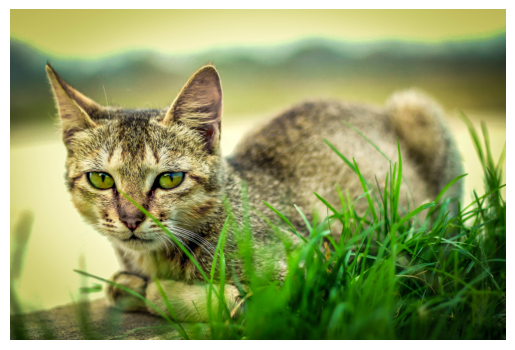

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# 图片路径
img_path = r"./images/cat.jpg"

# 读取并显示
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')  # 不显示坐标轴
plt.show()


### 从本地加载模型
比如你将模型下载到本地的`AI Infra/05Infer/06CompDistill/models`之后，便可以从本地模型目录进行加载了。我们加载刚刚准备的cat图片：

In [28]:
import os
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["HF_HUB_OFFLINE"] = "1"

import torch
from PIL import Image
from transformers import AutoTokenizer, AutoModelForCausalLM

MODEL_DIR = "./models/FastVLM-0.5B"
IMAGE_TOKEN_INDEX = -200  # 模型代码约定的占位 token id

# 1) 加载 tokenizer / 模型（trust_remote_code 很关键：启用仓库里的 llava_qwen.py）
tok = AutoTokenizer.from_pretrained(MODEL_DIR, trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_DIR,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    device_map="auto",                 # 或改成 .to("cuda") 手动放 GPU
    trust_remote_code=True,
)

# 2) 构造带 <image> 的聊天模板
messages = [{"role": "user", "content": "<image>\n 描述一下这张图片。"}]
rendered = tok.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
pre, post = rendered.split("<image>", 1)

pre_ids  = tok(pre,  return_tensors="pt", add_special_tokens=False).input_ids
post_ids = tok(post, return_tensors="pt", add_special_tokens=False).input_ids
img_tok  = torch.tensor([[IMAGE_TOKEN_INDEX]], dtype=pre_ids.dtype)
input_ids = torch.cat([pre_ids, img_tok, post_ids], dim=1).to(model.device)
attention_mask = torch.ones_like(input_ids, device=model.device)

# 3) 通过“模型自带”的 image_processor 做图像预处理（离线，不需要 preprocessor_config.json）
img_path = "./images/cat.jpg"   # 这里我选取的 cat 的图片
img = Image.open(img_path).convert("RGB")

px = model.get_vision_tower().image_processor(
    images=img, return_tensors="pt"
)["pixel_values"].to(model.device, dtype=model.dtype)

# 4) 生成
with torch.no_grad():
    out = model.generate(
        inputs=input_ids,
        attention_mask=attention_mask,
        images=px,
        max_new_tokens=128,
    )
print(tok.decode(out[0], skip_special_tokens=True))


这是一张拍摄时的猫的照片。这只猫躺在草地上，似乎很享受这片草地的地方。它看起来像是只年轻的猫咪，因为它在草地上也吃草了，也许是在那里玩或者只是为了放松而已。
这幅图片捕捉到了猫的好奇和满足感，展示了其在大自然环境下自由自在的样子，而且它被观察到躺在草地上这一点。




然而，由于没有关于猫颜色变化的因素，所以无法确信地说出这种猫的具体种类。
在专业领域、宠物领域或人类领域中发现的猫可能是任何一种


## 4. 准备评估函数

为了公平比较不同量化配置，我们需要相同的测评估方法。



### 模型加载函数

我们先写一个加载函数来加载模型

In [29]:

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

def load_fastvlm(model_path_or_id="apple/FastVLM-0.5B", prefer_fp16=None, device_map="auto"):
    """
    返回: tokenizer, model, image_processor, device, dtype
    - model_path_or_id: 可填 Hugging Face 仓库名，或本地目录路径
    - prefer_fp16: None=有 CUDA 则 FP16，否则 FP32
    """
    if prefer_fp16 is None:
        prefer_fp16 = torch.cuda.is_available()
    dtype = torch.float16 if prefer_fp16 else torch.float32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    tokenizer = AutoTokenizer.from_pretrained(model_path_or_id, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        model_path_or_id,
        torch_dtype=dtype,
        device_map=device_map,
        trust_remote_code=True,
    )
    image_processor = model.get_vision_tower().image_processor
    print(f"[Loaded] {model_path_or_id}  device={device}  dtype={dtype}")
    return tokenizer, model, image_processor, device, dtype

# 加载模型
tokenizer, model_fp16, image_processor, device, dtype = load_fastvlm(
    model_path_or_id="apple/FastVLM-0.5B",   # 你也可以换成本地路径
    prefer_fp16=True,                        # 使用 FP16（显存占用更小）
    device_map="auto"                        # 自动分配设备
)
model_name = "apple/FastVLM-0.5B"

# === 2. 定义图片和问题 ===
test_image = r"./images/cat.jpg"
test_question = "这张图片里有什么？"


[Loaded] apple/FastVLM-0.5B  device=cuda  dtype=torch.float16


利用`from_pretrained(...)`按名称或路径找到并实例化模型/分词器”,获取 `image_processor` 用于图像→`pixel_values` 的预处理，便于后续 `generate(inputs=..., images=...)` 推理。

### 评估函数

In [30]:
import time
import torch
from PIL import Image

def evaluate_model(
    model=None,
    image=r"./images/cat.jpg",  # 默认图片路径
    question="这张图片里有什么？",                        # 默认问题
    tokenizer=None,
    image_processor=None,
    device="cuda" if torch.cuda.is_available() else "cpu",  # 默认设备
    iterations=5,
    max_new_tokens=50):
    """
    评估 FastVLM：返回生成答案、平均延迟(ms)、显存占用(MB)。
    参数 image 可为 PIL.Image 或图片路径字符串。
    兼容多卡(device_map='auto')：文本张量放到嵌入层所在设备，图像张量放到视觉塔所在设备。
    """
    model.eval()
    IMAGE_TOKEN_INDEX = -200  # FastVLM 约定的图像占位 token

    # === 0) 识别实际设备（多卡时非常关键）
    text_device   = model.get_input_embeddings().weight.device
    vision_device = next(model.get_vision_tower().parameters()).device

    # === 1) 文本：用 chat 模板并在 <image> 处插入占位 token
    messages = [{"role": "user", "content": "<image>\n" + question}]
    rendered = tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=False)
    pre, post = rendered.split("<image>", 1)

    pre_ids  = tokenizer(pre,  return_tensors="pt", add_special_tokens=False).input_ids
    post_ids = tokenizer(post, return_tensors="pt", add_special_tokens=False).input_ids
    img_tok  = torch.tensor([[IMAGE_TOKEN_INDEX]], dtype=pre_ids.dtype)

    input_ids = torch.cat([pre_ids, img_tok, post_ids], dim=1).to(text_device)   # ← 文本到嵌入层所在设备
    attention_mask = torch.ones_like(input_ids, device=text_device)

    # === 2) 图像：用模型内置 image_processor 得到 pixel_values，并放到视觉塔所在设备
    if isinstance(image, str):
        img = Image.open(image).convert("RGB")
    else:
        img = image.convert("RGB")
    pixel_values = image_processor(images=img, return_tensors="pt")["pixel_values"]
    pixel_values = pixel_values.to(vision_device, dtype=model.dtype)              # ← 图像到视觉塔所在设备

    # === 3) 评测：多次生成取平均延迟
    if torch.cuda.is_available():
        # 分别对用到的 GPU 复位峰值 & 同步
        used_cuda = []
        for dev in {text_device, vision_device}:
            if isinstance(dev, torch.device) and dev.type == "cuda":
                torch.cuda.reset_peak_memory_stats(dev)
                used_cuda.append(dev)
        torch.cuda.synchronize()

    start = time.time()
    last_out = None
    for _ in range(iterations):
        with torch.no_grad():
            last_out = model.generate(
                inputs=input_ids,               # 注意：FastVLM 自定义 generate 接口是 inputs= + images=
                attention_mask=attention_mask,
                images=pixel_values,
                max_new_tokens=max_new_tokens,
            )
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    avg_latency_ms = (time.time() - start) / iterations * 1000.0

    # === 4) 显存占用（多卡求和；无 GPU 置 0）
    memory_used_mb = 0.0
    if torch.cuda.is_available():
        mem = 0
        for dev in {text_device, vision_device}:
            if isinstance(dev, torch.device) and dev.type == "cuda":
                mem += torch.cuda.max_memory_allocated(dev)
        memory_used_mb = mem / (1024 ** 2)

    answer = tokenizer.decode(last_out[0], skip_special_tokens=True)
    return {"answer": answer, "avg_latency_ms": avg_latency_ms, "memory_used_mb": memory_used_mb}


## 5. 基准测试：FP16 模型

让我们先测试原始的 FP16 模型作为基准：

In [31]:
# 清空缓存，确保测量准确
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.synchronize()

print("正在评估 FP16 模型...")

# iterations / max_new_tokens 可按需调整
fp16_results = evaluate_model(
    model_fp16,           # 来自 load_fastvlm() 返回的模型
    test_image,           # PIL.Image 或路径字符串
    test_question,        # 你的问题文本
    tokenizer,            # load_fastvlm() 返回
    image_processor,      # model.get_vision_tower().image_processor
    device,               # "cuda" 或 "cpu"
    iterations=5,
    max_new_tokens=50,
)

print("FP16 模型结果:")
print(f"答案: {fp16_results['answer']}")
print(f"平均延迟: {fp16_results['avg_latency_ms']:.2f} ms")
# 无 GPU 时 evaluate_model 会把显存占用置 0
print(f"显存占用: {fp16_results['memory_used_mb']:.2f} MB")

正在评估 FP16 模型...
FP16 模型结果:
答案: 这幅画的主题是一只年轻的灰虎斑猫，它正躺在长青地上安静地观察着周围的环境。这只猫被画框在绿色草地上，显示出它和平放松的举止。这张照片捕捉到了猫与草地之间
平均延迟: 705.43 ms
显存占用: 2547.38 MB


在进行评估前，我们调用了`torch.cuda.empty_cache()`来清空 GPU 缓存，确保显存测量的准确性。然后我们使用前面定义的评估函数来测试模型。

## 6. 量化配置 1：W8A8

现在让我们尝试 8 位量化，这是一种常用的平衡性能和精度的量化策略。

In [32]:
# 安装 bitsandbytes 库用于量化
!pip install bitsandbytes

# 加载 8 位量化模型
from transformers import BitsAndBytesConfig

# 配置 8 位量化参数
bnb_config_8bit = BitsAndBytesConfig(
    load_in_8bit=True,  # 启用 8 位量化
)

# 清空缓存
torch.cuda.empty_cache()

# 加载 8 位量化模型
print("正在加载 W8A8 量化模型...")
model_w8a8 = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config_8bit,
    device_map="auto"
)

# 评估 8 位量化模型
print("正在评估 W8A8 模型...")
w8a8_results = evaluate_model(
    model_w8a8, 
    test_image, 
    test_question, 
    tokenizer, 
    image_processor, 
    device
)

print(f"W8A8 模型结果:")
print(f"答案: {w8a8_results['answer']}")
print(f"平均延迟: {w8a8_results['avg_latency_ms']:.2f} ms")
print(f"显存占用: {w8a8_results['memory_used_mb']:.2f} MB")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


正在加载 W8A8 量化模型...
正在评估 W8A8 模型...
W8A8 模型结果:
答案: The image showcases a plain white background with a clear focus on a company logo in the top left corner, a partial view of a silver dog emoji, and a segment of a phone screen that is visible along with a label that reads "2"
 

平均延迟: 3271.41 ms
显存占用: 3372.49 MB


这里我们使用了 bitsandbytes 库提供的 8 位量化功能。通过设置`load_in_8bit=True`，我们告诉库将模型权重加载为 8 位整数。

理论上，8 位量化可以将模型大小减少约 4 倍（从 32 位浮点数到 8 位整数），但实际显存节省可能略少，因为还需要存储一些量化参数（如缩放因子）。

## 7. 量化配置 2：W4A4

接下来，我们尝试更激进的 4 位量化，这会进一步减少模型大小和显存占用。

In [33]:
# 配置 4 位量化参数
bnb_config_4bit = BitsAndBytesConfig(
    load_in_4bit=True,  # 启用 4 位量化
    bnb_4bit_use_double_quant=True,  # 使用双量化，进一步节省空间
    bnb_4bit_quant_type="nf4",  # 使用正态分布量化
)

# 清空缓存
torch.cuda.empty_cache()

# 加载 4 位量化模型（W4A4）
print("正在加载 W4A4 量化模型...")
model_w4a4 = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config_4bit,
    device_map="auto"
)

# 评估 4 位量化模型
print("正在评估 W4A4 模型...")
w4a4_results = evaluate_model(
    model_w4a4, 
    test_image, 
    test_question, 
    tokenizer, 
    image_processor, 
    device
)

print(f"W4A4 模型结果:")
print(f"答案: {w4a4_results['answer']}")
print(f"平均延迟: {w4a4_results['avg_latency_ms']:.2f} ms")
print(f"显存占用: {w4a4_results['memory_used_mb']:.2f} MB")

正在加载 W4A4 量化模型...
正在评估 W4A4 模型...
W4A4 模型结果:
答案: 这张照片捕捉到了一只猫躺在草上的瞬间。猫蜷缩在它自然的绿色环境中休息或放松，周围环绕着茂盛的青草。这是一张非常美丽的和令人赏心悦目的猫与大自然接触的时刻
平均延迟: 1372.24 ms
显存占用: 4011.37 MB


在 4 位量化配置中，我们使用了一些额外的优化：

- `bnb_4bit_use_double_quant=True`：启用双量化，对量化参数本身也进行量化
- `bnb_4bit_quant_type="nf4"`：使用正态分布感知量化，这通常比均匀量化保留更好的精度

4 位量化理论上可以比 32 位浮点数减少 8 倍的存储空间，是资源受限环境下的理想选择。

## 8. 量化配置 3：W4A16

最后，我们测试一种混合量化策略：权重使用 4 位，激活使用 16 位。这种配置试图在节省显存和保持推理精度之间取得更好的平衡。

In [34]:
# 配置 W4A16 量化参数
bnb_config_w4a16 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16  # 计算使用 16 位浮点数
)

# 清空缓存
torch.cuda.empty_cache()

# 加载 W4A16 量化模型
print("正在加载 W4A16 量化模型...")
model_w4a16 = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config_w4a16,
    device_map="auto"
)

# 评估 W4A16 量化模型
print("正在评估 W4A16 模型...")
w4a16_results = evaluate_model(
    model_w4a16, 
    test_image, 
    test_question, 
    tokenizer, 
    image_processor, 
    device
)

print(f"W4A16 模型结果:")
print(f"答案: {w4a16_results['answer']}")
print(f"平均延迟: {w4a16_results['avg_latency_ms']:.2f} ms")
print(f"显存占用: {w4a16_results['memory_used_mb']:.2f} MB")

正在加载 W4A16 量化模型...


正在评估 W4A16 模型...
W4A16 模型结果:
答案: 在这幅图片中，一只猫正躺在一片长着青草的草地上。这只猫身上有褐色、黄色和灰色的斑纹，它的脸和后腿上清晰可见。场景给人一种宁静感，猫儿们似乎正在
平均延迟: 1199.19 ms
显存占用: 4651.97 MB


这里的关键参数是`bnb_4bit_compute_dtype=torch.float16`，它指定了在计算过程中（主要是激活值）使用 16 位浮点数，而不是 4 位整数。这种配置可以减少量化误差，尤其是在激活值动态范围较大的情况下。

## 9. 实验结果对比与分析

现在让我们汇总所有实验结果，进行对比分析：

In [35]:
# 汇总结果
results = {
    "FP16": fp16_results,
    "W8A8": w8a8_results,
    "W4A4": w4a4_results,
    "W4A16": w4a16_results
}

# 打印对比表格
print(f"{'配置':<8} {'延迟(ms)':<10} {'显存(MB)':<10}")
print("-" * 30)
for config, res in results.items():
    print(f"{config:<8} {res['avg_latency_ms']:<10.2f} {res['memory_used_mb']:<10.2f}")

# 计算相对值（相对于 FP16）
print("\n 相对值（相对于 FP16）:")
print(f"{'配置':<8} {'延迟比例':<10} {'显存比例':<10}")
print("-" * 30)
fp16_latency = results["FP16"]["avg_latency_ms"]
fp16_memory = results["FP16"]["memory_used_mb"]

for config, res in results.items():
    latency_ratio = res["avg_latency_ms"] / fp16_latency
    memory_ratio = res["memory_used_mb"] / fp16_memory
    print(f"{config:<8} {latency_ratio:<10.2f} {memory_ratio:<10.2f}")

配置       延迟(ms)     显存(MB)    
------------------------------
FP16     705.43     2547.38   
W8A8     3271.41    3372.49   
W4A4     1372.24    4011.37   
W4A16    1199.19    4651.97   

 相对值（相对于 FP16）:
配置       延迟比例       显存比例      
------------------------------
FP16     1.00       1.00      
W8A8     4.64       1.32      
W4A4     1.95       1.57      
W4A16    1.70       1.83      


这段代码会以表格形式展示所有配置的延迟和显存占用，并计算它们相对于 FP16 基准的比例。

从理论上我们可以预期：

- 显存占用：W4A4 < W4A16 < W8A8 < FP16
- 推理延迟：通常量化程度越高，延迟越低，但这也取决于硬件支持

除了这些数值指标，我们还应该关注模型的输出质量是否有明显下降。如果量化后的模型生成的答案质量严重下降，那么即使显存和延迟有优势，这种量化配置也可能不适用。

## 10. 总结与思考

在显存占用方面，4 位量化（W4A4 和 W4A16）相比 FP16 可以节省显著的显存空间，通常能达到 70-80%的减少，而 8 位量化（W8A8）则可以节省约 40-50%的显存。这种显存占用的减少对于在资源受限设备上部署大模型尤为重要。

推理延迟方面，量化通常会带来推理速度的提升，但提升幅度取决于具体硬件和量化实现。一般来说，4 位量化可能比 8 位量化更快，但也可能因为需要更多的反量化操作而抵消部分优势。实际测量中，W4A16 配置通常在延迟和精度之间提供了较好的平衡。

精度权衡是量化技术中需要重点考虑的因素。更高程度的量化（如 W4A4）可能会导致模型精度下降，特别是在复杂任务上。W4A16 这种混合配置通常能在节省显存和保持精度之间取得更好的平衡，尤其是对于多模态模型中的视觉特征处理部分。